In [53]:
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
import math
import ipywidgets as widgets
from IPython.display import display, Markdown, Latex
import sympy
# from sympy import *
# from sympy.physics.units import *

%matplotlib inline

# Speed of sound
c = 343
max_vel = 30

def display_var(var, value, unit=None, preface=None):
    display(Markdown("$\\text{{ {}${} = {:.3f} \\text{{ {} }} $ }} $".format(preface or "", var, value, unit or "")))

def plot(data):
    plt.plot(data)
    plt.show()

# Pi Echo

_Introduction_

## Background


## Aproach
### Simulation

Simulating a system like this is actually rather straight forward. The goal of each simulation is to determine the performance of each set of parameters. The key parameters are the sample frequency, $f_s$, which affects the limits of all other parameters and performance characteristics. Primarily, it determines the highest frequency which can be detected by the system, in accordance with the Nyquist Sampling Theorm $f_s > 2f_{max}$. In our application, $f_{max}$ is going to be the emitted frequency doppler shifted by the maximum speed we want to detect. In general, the doppler shift will be very small compared to the frequency itself, so we'll generalize the constraint to be

$$ f_s > 2f_0 $$

where f_0 is the emitted frequency. $f_0$ itself affects the performance characteristics a marginal amount. The doppler effect is defined as

$$ f_{doppler} = {c \over c+v} f_0 $$

When a standard Discrete Fourier Transform is used to find frequencies, a higher $f_0$ will result in a proportional shift in $f_{doppler}$ as a result, which will span more frequency bins in the transform.

In [54]:
c = 343 # m/s

# Returns the frequency shifted by the doppler effect for a given velocity 'v'
def doppler(f0, v):
    return c / (c + v) * f0

display_var("f_0 - f_{doppler}", 5000 - doppler(5000, 1), "Hz", " for $f_0 = 5000$ Hz: ")
display_var("f_0 - f_{doppler}", 22000 - doppler(22000, 1), "Hz", " for $f_0 = 22000$ Hz: ")

$\text{  for $f_0 = 5000$ Hz: $f_0 - f_{doppler} = 14.535 \text{ Hz } $ } $

$\text{  for $f_0 = 22000$ Hz: $f_0 - f_{doppler} = 63.953 \text{ Hz } $ } $

The next important parameter is $n_s$, which is the number of samples used for each Fourier Transform. First and foremost, $n_s$ determines the amount of time over which samples are gathered for one calculation, $T_{FFT}$. 

$$ T_{FFT} = T_s n_s = {n_s \over f_s} $$

In [55]:
# Returns the sample period given a sample frequency
def sample_period(f_s):
    return 1 / f_s

# Returns the time (in seconds) over which one transform would be calculated
def fft_period(T_s, n):
    return T_s * n

display_var("T_s", sample_period(44100) * 1000, "ms")
display_var("T_{FFT}", fft_period(sample_period(44100), 8192) * 1000, "ms")

$\text{ $T_s = 0.023 \text{ ms } $ } $

$\text{ $T_{FFT} = 185.760 \text{ ms } $ } $

The number of samples also defines the number of frequency bins that will be in the resulting Transform $2n_{bins} = n_s$. The more frequency bins there are, the higher the resolution of the spectrum, $f_{bin}$ since those bins are distributed over the Nyquist frequency $f_s \over 2$.

In [56]:
# Returns the number of hertz per frequency bin in the fft
def freq_per_bin(T_s, n):
    return 1 / fft_period(T_s, n)

''' For a given set of parameters, returns the resolution with which
    the system will be able to detect the doppler effect.
    Essentially by resolution we mean the number of bins that span
    the range of velocities we want to detect.
'''
def resolution(T_s, n, f0, vmax):
    return abs(int((doppler(f0, vmax) - f0) / freq_per_bin(T_s, n)))

display_var("f_{bin}", freq_per_bin(sample_period(44100), 8192), "Hz")
display_var("\\text{resolution}", resolution(sample_period(44100), 8192, 22000, 1))

$\text{ $f_{bin} = 5.383 \text{ Hz } $ } $

$\text{ $\text{resolution} = 11.000 \text{  } $ } $

In general, $n_{s}$ will also be chosen as a power of 2 as FFT algorithms run most efficently for those sample counts.

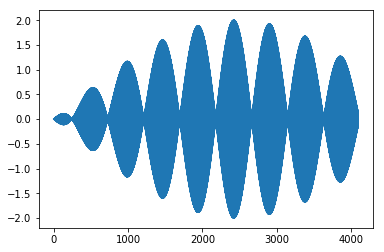

In [60]:
''' Generates the signal received by a sensor at 'sensor' and a target object
    at 'start' moving at a 'velocity' due to the doppler effect of the
    frequency 'f0'
'''
def signal_gen(T_s, n, sensor, start, velocity, f0):
    t = 0
    for i in range(n):
        r = sensor - start + velocity*t
        w = np.dot(velocity, r / la.norm(r))
        f = doppler(f0, w)
        yield math.sin(2*math.pi*f*t) + math.sin(2*math.pi*f0*t)
        t += T_s
        
f0 = 22000
f_s = 44100
T_s = sample_period(f_s)
n = 4096

signal = list(
    signal_gen(
        T_s
        , 4096
        , np.array([0, 0])
        , np.array([1,1])
        , np.array([1,1])
        , f0
    )
)
plot(signal)

$\text{ $n_{bins} = 2049.000 \text{  } $ } $

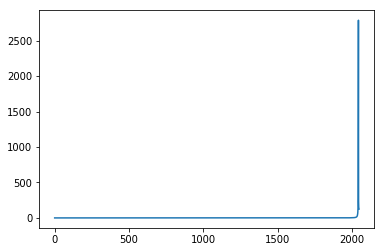

In [61]:
def freq_spectrum(signal):
    return [np.absolute(sample) for sample in np.fft.rfft(signal)]

spectrum = freq_spectrum(signal)
n_bins = len(spectrum)
display_var("n_{bins}", n_bins)
plot(spectrum)

In [68]:
# Finds a local min
def find_next_low(data):
    minv = None
    for i, v in enumerate(data):
        if minv is None:
            minv = v
        elif v < minv:
            minv = v
        else:
            return i-1
    return len(data)


# Finds the global max starting at the first local min
def find_next_peak(data):
    maxv = 0
    ret = 0
    start = find_next_low(data)
    data = data[start:]
    for i, v in enumerate(data):
        if v > maxv:
            maxv = v
            ret = i   
    return start + ret

# Returns mean and standard deviation of input data
def characterize_peak(data):
    sumweight = 0
    sumdata = 0
    for i, v in enumerate(data):
        sumweight += v
        sumdata += i*v

    mean = sumdata / sumweight

    variance = 0
    for i, v in enumerate(data):
        variance += v / sumweight * (mean - i)**2

    std_dev = math.sqrt(variance)

    return (mean, std_dev)

''' Finds the doppler shifted frequency in a spectrum about f0.
    Returns the mean and standard deviation
'''
def find_shift(T_s, f0, spectrum):
    samples = (len(spectrum)-1)*2
    fpb = freq_per_bin(T_s, samples)

    peak_range = doppler(f0, max_vel)

    f0_bin = round(f0 / fpb)
    bin_range = int(peak_range / fpb)

    # Find highest bin in search range to left and right of f0 peak
    left_peak = f0_bin - find_next_peak(spectrum[f0_bin:f0_bin-bin_range:-1])
    right_peak = f0_bin + find_next_peak(spectrum[f0_bin:f0_bin+bin_range])

    max_peak = max((left_peak, right_peak),
                key=lambda x: spectrum[x] if 0 <= x < len(spectrum) else 0)

    peak_start = find_next_low(spectrum[max_peak:max_peak-bin_range:-1])
    peak_end = find_next_low(spectrum[max_peak:max_peak+bin_range])

    # symmetry
    peak_start = peak_end = min(peak_start, peak_end)

    mean, std_dev = characterize_peak(spectrum[max_peak-peak_start:max_peak+peak_end])
    mean += max_peak-peak_start

    freq_mean = mean*fpb
    std_dev = std_dev*fpb

    return freq_mean - f0, std_dev

shift, sigma = find_shift(T_s, f0, spectrum)
display_var("f_{\\text{shift}}", shift, "Hz", "Frequency Shift: ")

$\text{ Frequency Shift: $f_{\text{shift}} = 3.826 \text{ Hz } $ } $

In [69]:
# Returns the velocity based on the known frequency shift
def inv_doppler(f0, df):
    return df/f0*c

dopple_v = inv_doppler(f0, shift)
dopple_sigma = inv_doppler(f0, sigma)
display_var("v_\\text{doppler}", dopple_v, "m/s", "Doppler Velocity: ")

$\text{ Doppler Velocity: $v_\text{doppler} = 0.060 \text{ m/s } $ } $